In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import cv2

In [12]:
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

X = np.concatenate((x_train, x_test), axis=0)
Y = np.concatenate((y_train, y_test), axis=0)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1234)

## Chain Code

In [14]:
def min_circular_shift(seq):
    min_shift = seq
    for i in range(1, len(seq)):
        shifted_seq = seq[i:] + seq[:i]
        if shifted_seq < min_shift:
            min_shift = shifted_seq
    return min_shift

In [15]:
def extract_chain_code_features(image):

    directions = [(0, -1), (-1, -1), (-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1)]
    ret, bin_img = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    height, width = bin_img.shape

    # Find the first white pixel
    for x in range(height):
        for y in range(width):
            if bin_img[x][y] == 255:
                start_pos = (x, y)
                break
        else:
            continue
        break
    else:
        return []

    current_pos = start_pos
    check_dir = 0
    chain_code = []

    while True:
        for i in range(8):
            dir_index = (check_dir + i) % 8
            dx, dy = directions[dir_index]
            next_pos = (current_pos[0] + dx, current_pos[1] + dy)
            if 0 <= next_pos[0] < height and 0 <= next_pos[1] < width and bin_img[next_pos] == 255:
                if directions[dir_index] == (1, 0):
                    code = 0
                elif directions[dir_index] == (1, 1):
                    code = 1
                elif directions[dir_index] == (0, 1):
                    code = 2
                elif directions[dir_index] == (-1, 1):
                    code = 3
                elif directions[dir_index] == (-1, 0):
                    code = 4
                elif directions[dir_index] == (-1, -1):
                    code = 5
                elif directions[dir_index] == (0, -1):
                    code = 6
                elif directions[dir_index] == (1, -1):
                    code = 7
                chain_code.append(code)
                check_dir = (dir_index + 5) % 8
                current_pos = next_pos
                break
        else:
            break
        if current_pos == start_pos:
            break

    if not chain_code:
        return []

    min_shift = min_circular_shift(chain_code)
    return min_shift

In [16]:
extracted_features = []
for image in X_train:
    chain_code = extract_chain_code_features(image)
    extracted_features.append(chain_code)

In [17]:
max_length = max(map(len, extracted_features))
final_features = []
for chain in extracted_features:
    chain_code = chain + [0] * (max_length - len(chain))
    final_features.append(chain_code)

In [18]:
chain_features = np.array(final_features)

## Centroid

In [20]:
def extract_centroid_features(X, n_blocks):
    n_samples ,width, height = X.shape
    z = int(np.sqrt(n_blocks))
    block_dim = width // z
    extracted_features = np.zeros((n_samples,n_blocks*2))

    x = np.arange(width).reshape(-1,1)
    y = np.arange(height)

    for sample in range(n_samples):
        centroids = []
        for i in range(z):
            for j in range(z):
                if i == z-1 and j == z-1:
                    block = X[sample, i*block_dim:, j*block_dim:]
                    total_sum = np.sum(block)
                    if total_sum > 0:
                        x_bar = np.sum(x[i*block_dim:] * block) / total_sum
                        y_bar = np.sum(y[j*block_dim:]*block) / total_sum

                    else:
                        x_bar = y_bar = 0
                    centroids.append(x_bar)
                    centroids.append(y_bar)

                elif i == z-1:
                    block = X[sample, i*block_dim:, j*block_dim:(j+1)*block_dim]
                    total_sum = np.sum(block)
                    if total_sum > 0:
                        x_bar = np.sum(x[i*block_dim:]*block) / total_sum
                        y_bar = np.sum(y[j*block_dim:(j+1)*block_dim]*block) / total_sum
                    else:
                        x_bar = y_bar = 0
                    centroids.append(x_bar)
                    centroids.append(y_bar)


                elif j == z-1:
                    block = X[sample, i*block_dim:(i+1)*block_dim, j*block_dim:]
                    total_sum = np.sum(block)
                    if total_sum > 0:
                        x_bar = np.sum(x[i*block_dim:(i+1)*block_dim]*block) / total_sum
                        y_bar = np.sum(y[j*block_dim:]*block) / total_sum
                    else:
                        x_bar = y_bar = 0
                    centroids.append(x_bar)
                    centroids.append(y_bar)

                else:
                    block = X[sample,i*block_dim:(i+1)*block_dim,j*block_dim:(j+1)*block_dim]
                    total_sum = np.sum(block)
                    if total_sum > 0:
                        x_bar = np.sum(x[i*block_dim:(i+1)*block_dim]*block) / total_sum
                        y_bar = np.sum(y[j*block_dim:(j+1)*block_dim]*block) / total_sum
                    else:
                        x_bar = y_bar = 0
                    centroids.append(x_bar)
                    centroids.append(y_bar)

        extracted_features[sample] = np.array(centroids)

    return extracted_features

In [21]:
centroid_features = extract_centroid_features(X_train, n_blocks=9)

## Kmeans Clustering

In [29]:
class Kmeans:

  def __init__(self,k=10):
    self.k = k
    self.centroids = None

  def euclidean_distance(self, data, centroids):
    return np.sqrt(np.sum((data - centroids[:, np.newaxis])**2, axis=2))

  def fit(self, X, max_iter=200):

    np.random.seed(1234)
    self.centroids = X[np.random.choice(X.shape[0], self.k, replace=False)]

    for _ in range(max_iter):

      distances = self.euclidean_distance(X, self.centroids)
      labels = np.argmin(distances, axis=0)


      new_centroids = np.array([X[labels == cluster].mean(axis=0) for cluster in range(self.k)])

      if np.allclose(self.centroids, new_centroids):
        break

      self.centroids = new_centroids

    return labels

In [30]:
model = Kmeans(10)
centroid_labels = model.fit(centroid_features)
chain_labels = model.fit(chain_features)

In [31]:
from sklearn.metrics import confusion_matrix
centroid_confusion = confusion_matrix(y_train,centroid_labels,labels=list(np.arange(0,10)))
chain_confusion = confusion_matrix(y_train,chain_labels,labels=list(np.arange(0,10)))

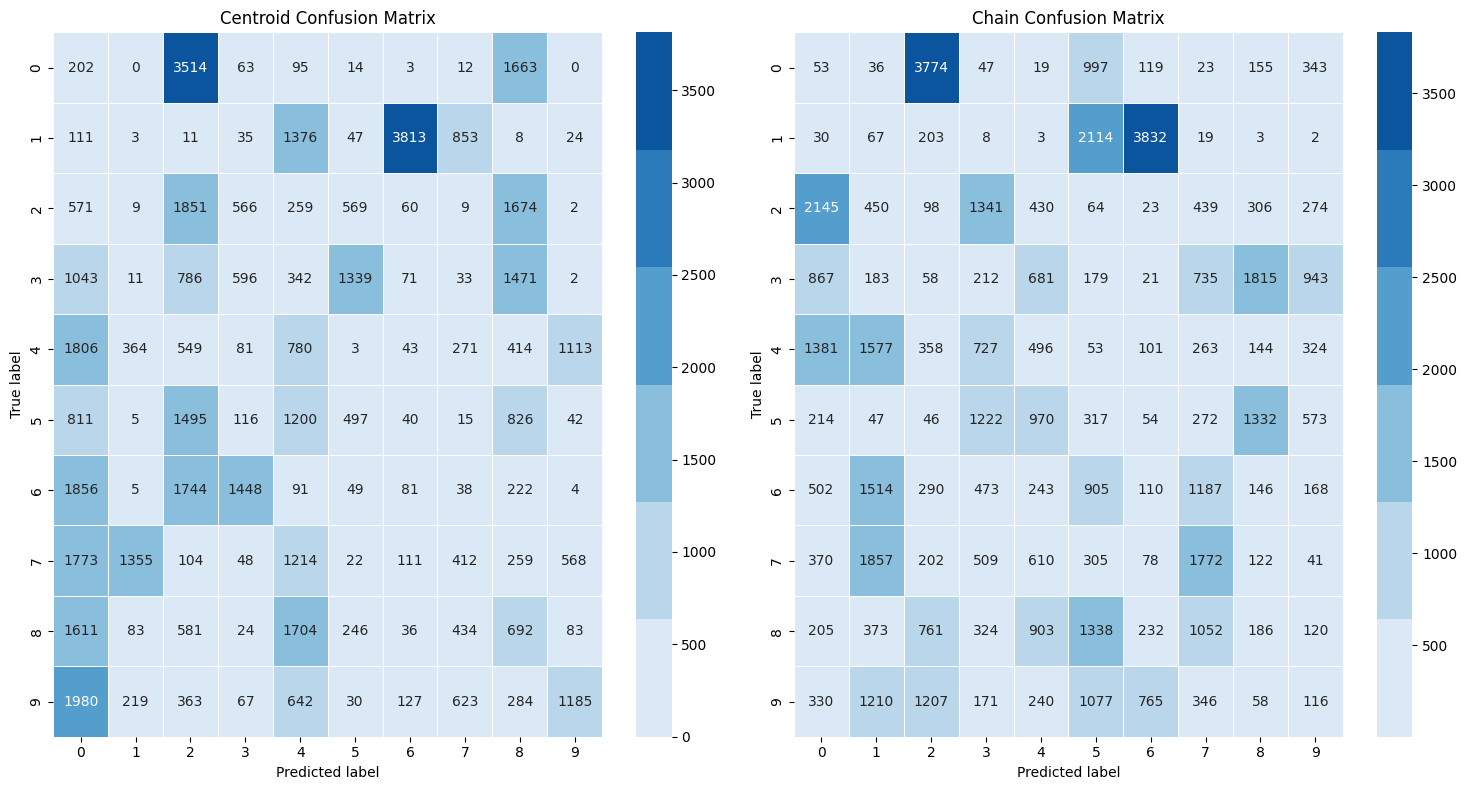

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2,figsize=(15,8))

sns.heatmap(centroid_confusion, annot=True,ax=axes[0],fmt="d",linewidths=.5,cmap=sns.color_palette("Blues"))
axes[0].set(title='Centroid Confusion Matrix', xlabel='Predicted label', ylabel='True label')

sns.heatmap(chain_confusion, annot=True,ax=axes[1],fmt="d",linewidths=.5,cmap=sns.color_palette("Blues"))
axes[1].set(title='Chain Confusion Matrix', xlabel='Predicted label', ylabel='True label')

plt.tight_layout()
plt.show()